In [1]:
import torch
import numpy as np
import os
import pandas as pd
import datasets

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090 Ti'

In [3]:
%matplotlib inline
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import cv2

In [4]:
train_folder = ImageFolder(root="train")
val_folder = ImageFolder(root="train")
test_set = ImageFolder(root="test")
train_set, val_set = torch.utils.data.random_split(train_folder, [0.8,0.2])
val_set.dataset = val_folder

In [5]:
transform_train = transforms.Compose([
    transforms.Resize((1024, 1024), antialias=True),
    transforms.RandomRotation((-35, 35)),
    transforms.CenterCrop(size=(900, 900)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=.2),
    #transforms.ColorJitter(brightness=.5, contrast=.2, hue=.2, saturation=.2)
    #transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    #transforms.RandomErasing(1, scale=(0.1, 0.1), ratio=(1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
    
])
transform_val = transforms.Compose([
    transforms.Resize((1024, 1024),antialias=True),
    transforms.CenterCrop(size=(900, 900)),
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_set.dataset.transform=transform_train
val_set.dataset.transform=transform_val
test_set.transform=transform_val


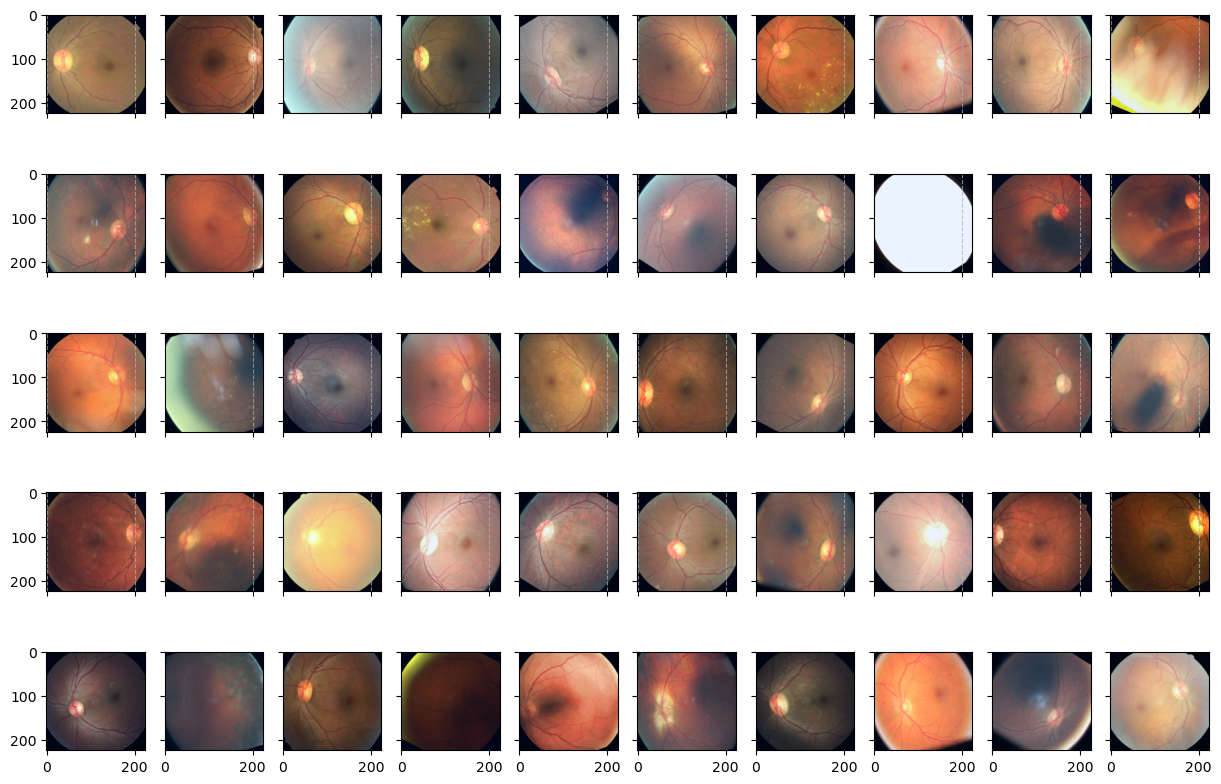

In [85]:
# Create a DataLoader
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
figs, axs = plt.subplots(5,10, figsize=(15, 10))
for col in range(1,10):
    for ax in axs[:, col]:
        ax.yaxis.set_ticklabels([])

# Set x-grid only for the lower subplots
for row in range(4):
    for ax in axs[row, :]:
        ax.xaxis.set_ticklabels([])
        ax.xaxis.grid(True, linestyle='--', alpha=0.7)
axs=axs.flatten()

for i, (inputs, labels) in enumerate(train_loader):
    if i < 1:
        for j in range(50):
            #bs, ncrops, c, h, w = inputs.size()
            
            #img = np.array(inputs.view(-1, c, h, w)[j].permute(1, 2, 0) )
            img = np.array(inputs[j].permute(1, 2, 0) )
            img = (img - img.min()) / (img.max() - img.min()) # Broadcasting rules apply
            axs[j].imshow(img)
            
    else:
        break
plt.show()

In [7]:
from torchvision.models import ResNet152_Weights
import torch
from trainer import PTTrainer
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
import time
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# Modify the output layer to match the number of classes in your dataset
num_classes = len(train_set.dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

resnet = PTTrainer(model)
resnet_history = resnet.train(train_loader=train_loader,
             val_loader=val_loader,
             epochs=30,
             lr=0.001,
             device="cuda",
             patience=5,
             log=True)


2023-12-18 21:32:30.684357: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 21:32:30.698099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 21:32:30.698115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 21:32:30.698560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 21:32:30.701150: I tensorflow/core/platform/cpu_feature_guar

Epoch 0 running
Train Acc: 41.51% Loss: 1.31 Time: 72s
Validation Acc: 41.83% Loss: 1.29 Time: 84s
Epoch 1 running
Train Acc: 49.17% Loss: 1.16 Time: 156s
Validation Acc: 42.19% Loss: 1.30 Time: 167s
Epoch 2 running
Train Acc: 50.86% Loss: 1.10 Time: 239s
Validation Acc: 39.18% Loss: 1.43 Time: 251s
Epoch 3 running
Train Acc: 51.93% Loss: 1.08 Time: 323s
Validation Acc: 41.71% Loss: 1.29 Time: 334s


In [ ]:
from trainer import HFTrainer
from transformers import BitForImageClassification, BitImageProcessor, ViTForImageClassification, ViTImageProcessor

# create optimizer wight weigh decay
model_name = "google/bit-50"
model = BitForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_folder.class_to_idx),
    id2label=train_folder.class_to_idx,
    label2id={v: k for k, v in train_folder.class_to_idx.items()},
    ignore_mismatched_sizes=True
)
processor = BitImageProcessor.from_pretrained(model_name)

bit = HFTrainer(model, processor)
bit_history =bit.train(train_set=train_loader,
          val_set=val_loader,
          bs=batch_size,
          epochs=30,
          lr=2e-4,
          patience=5,
          report_to="",
          log=True)
model_name = "google/vit-base-patch32-384"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_folder.class_to_idx),
    id2label=train_folder.class_to_idx,
    label2id={v: k for k, v in train_folder.class_to_idx.items()},
    ignore_mismatched_sizes=True
)
processor = ViTImageProcessor.from_pretrained(model_name)

vit = HFTrainer(model, processor)
vit_history = vit.train(train_set=train_loader,
          val_set=val_loader,
          bs=batch_size,
          epochs=30,
          lr=2e-4,
          patience=5,
          report_to="",
          log=True)

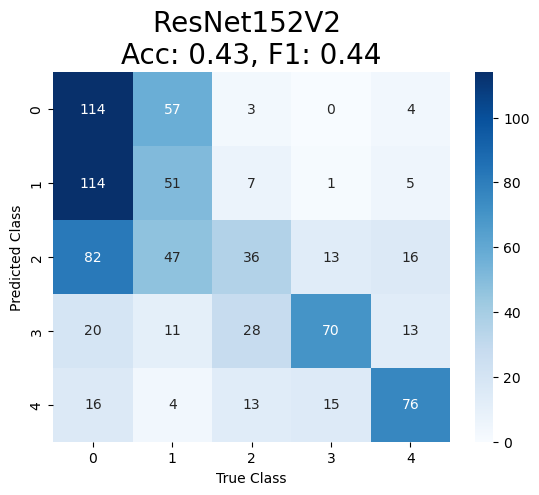

In [102]:
import seaborn as sn
from sklearn import metrics
label, pred = resnet.validate(test_loader=test_loader, device="cuda")
ax = sn.heatmap(metrics.confusion_matrix(label, pred), annot=True, cmap="Blues", fmt='g')
ax.set(xlabel="True Class", ylabel="Predicted Class")
ax.set_title(f"ResNet152V2 \nAcc: {round(metrics.accuracy_score(label, pred), 2)}, F1: {round(metrics.f1_score(label, pred, average='macro'), 2)}", fontsize=20)
plt.show()

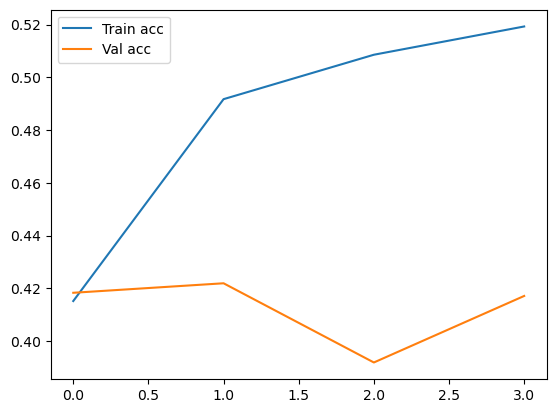

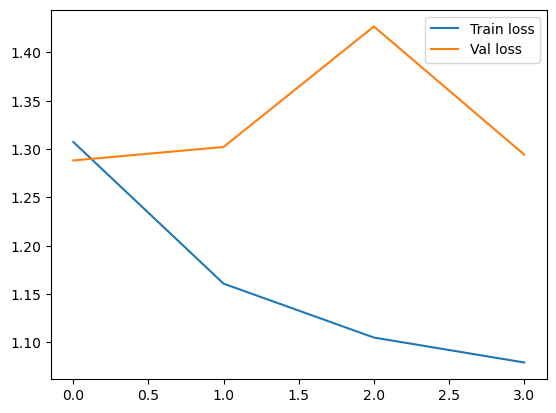

In [107]:
fig, axs = plt.subplots(2, 2, sigsize=(7, 7))
axs = axs.flatten()
for i, (set, metric) in enumerate([["Train", "accuracy"], ["Test", "accuracy"], ["Train", "loss"], ["Test", "loss"]]):
    axs[i].plot(resnet_history[i], label=f"{set} {metric}") 
plt.legend()
plt.show()

In [33]:
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz




Predicted: 4


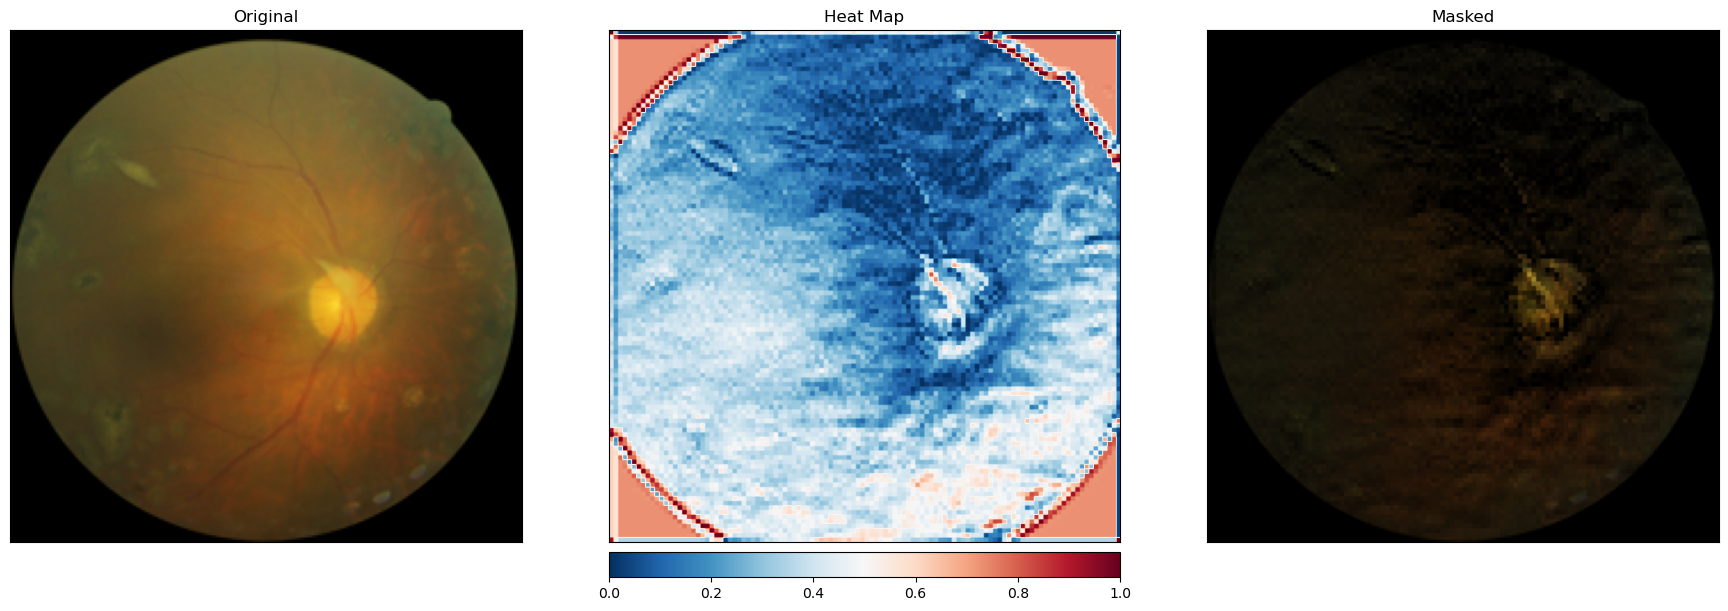

Predicted: 2


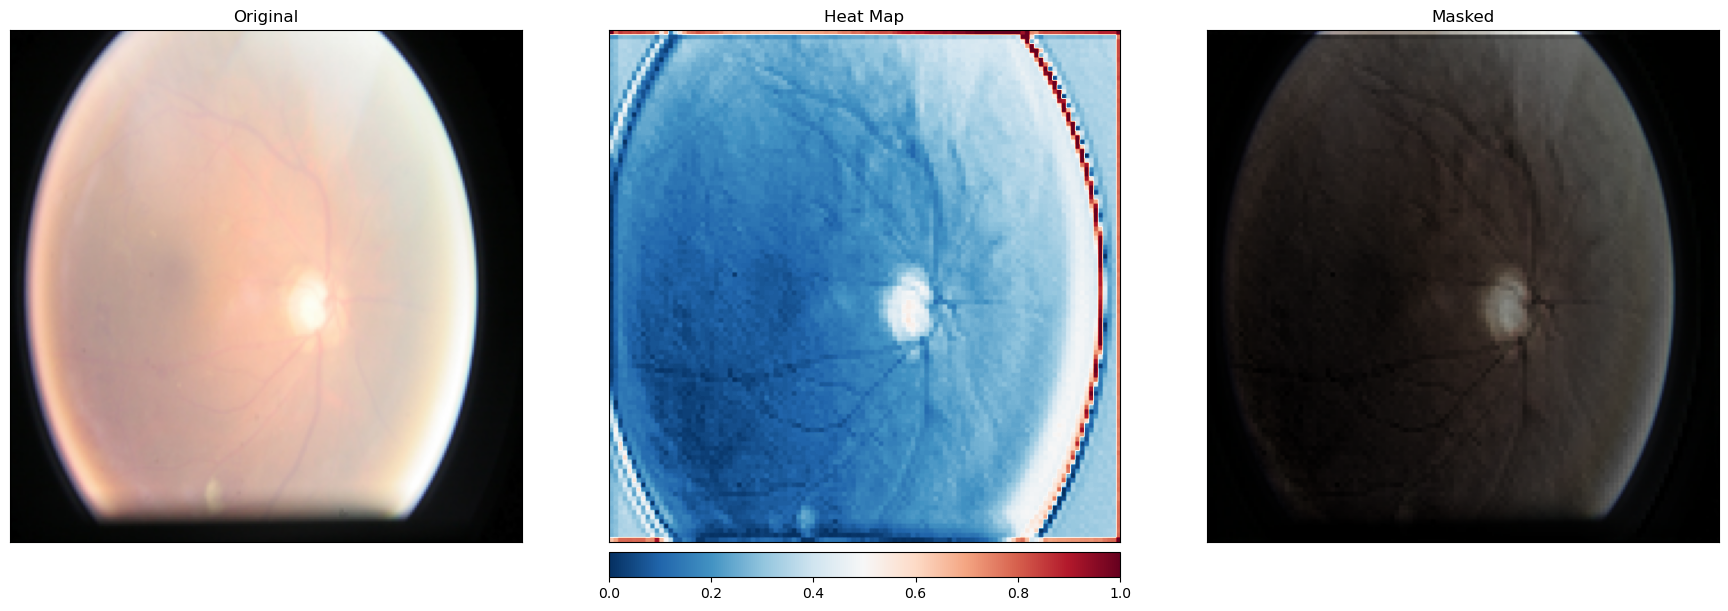

Predicted: 2


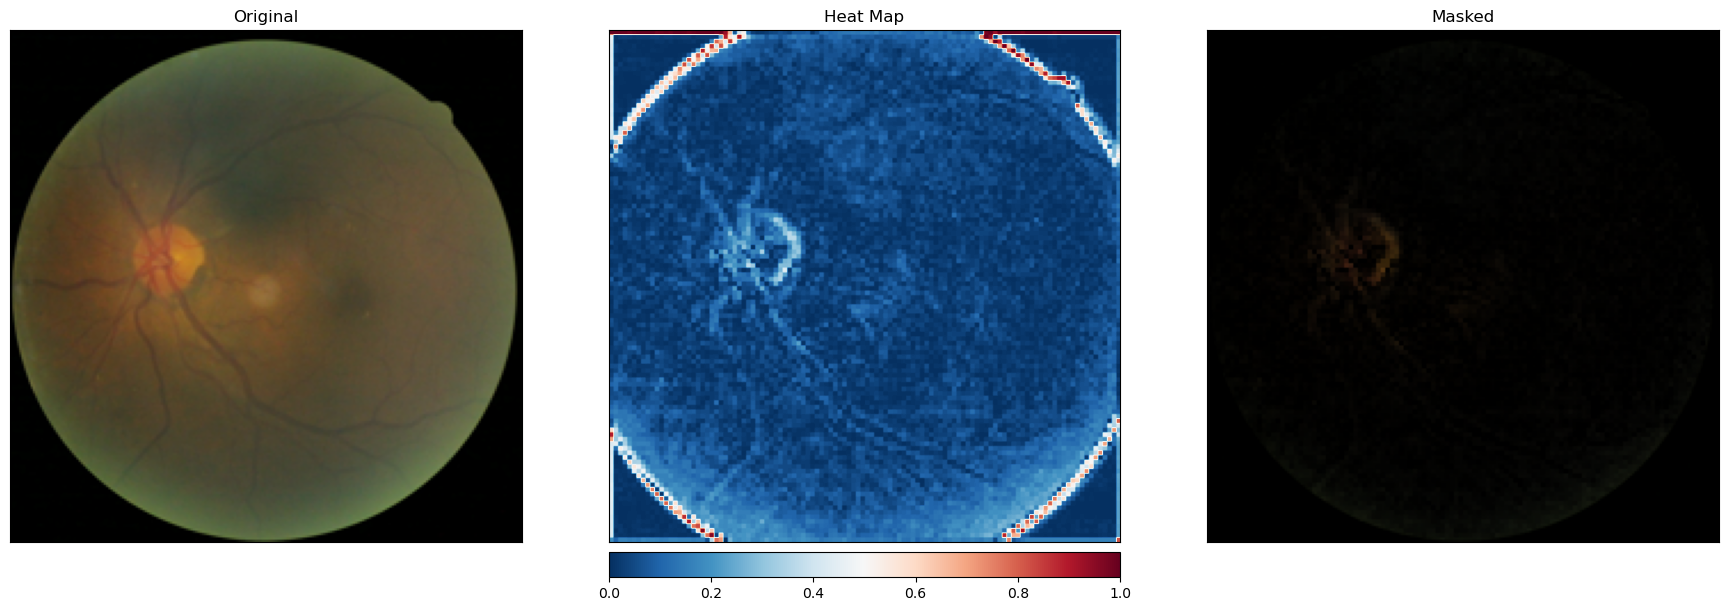

Predicted: 0


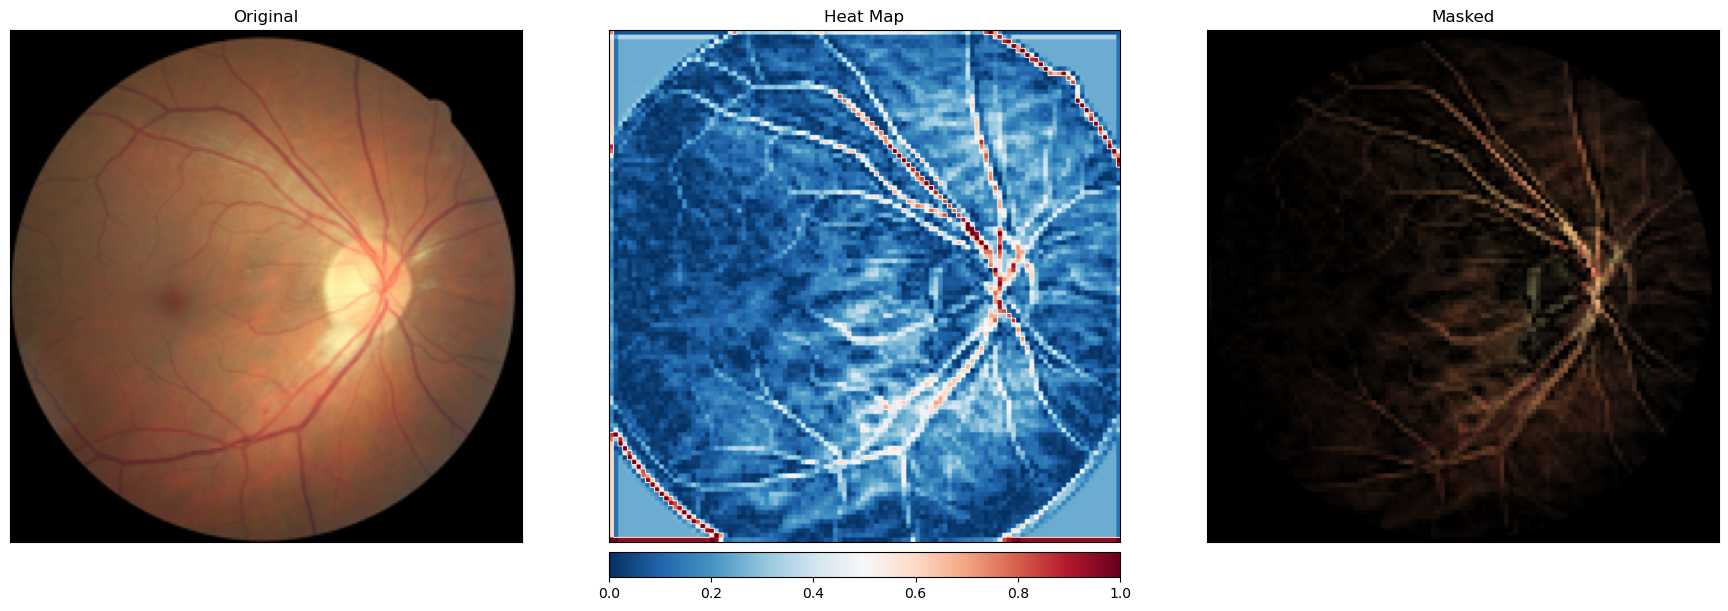

In [83]:
from captum.attr import LayerAttribution
from captum.attr import LayerGradCam
model = model.to("cpu")
conv_layers = [module for module in model.modules() if isinstance(module, torch.nn.Conv2d)]
target_layer = conv_layers[0]

layer_gradcam = LayerGradCam(model, target_layer)
#layer_gradcam = IntegratedGradients(model)#, target_layer)

for img_path in ["test/4/406_right.jpeg", "test/3/679_left.jpeg", "test/2/1030_left.jpeg", "test/1/1343_right.jpeg", "test/0/1037_left.jpeg"]:
    img = Image.open(img_path)
    img_transform = transform_val(img)
    attributions_lgc = layer_gradcam.attribute(img_transform.unsqueeze(0), target=[4])
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, img_transform.shape[1:])
    
    print("Predicted:",int(torch.argmax(model(img_transform.unsqueeze(0)))))
    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                          np.array(img.resize((224, 224))),
                                          ["original_image","heat_map","masked_image"],
                                          ["all","absolute_value","absolute_value"],
                                          show_colorbar=True,
                                          titles=["Original","Heat Map",  "Masked"],
                                          fig_size=(18, 6), cmap="RdBu_r")